<a href="https://colab.research.google.com/github/chaitubhure/HEADS_HOST_2023_SCS/blob/main/CNN_Implementation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Intructions for running the notebook in Google Colab**



*   Run code cells in order
*   To generate predictions using a saved model go to Section 4. Model will be provided as an .h5 file in the accompanying zip file as part of the submission. Run the code cells in order in section 4 to evaluate the result.
*   For training the model again, connect to a GPU runtime in Google Colab. This model trained for 10 minutes and was able to achieve 70% accuracy.

The file structure for storing images as input to this notebook is as follows:

Competition Materials

    --Train
      --Training Images
        --Images used for training
      --Train Labels
    --Test
      --Test Images
        --Images used for testing
      --Test Labels

In [ ]:
# Initialize GPU on Google Colab
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Section 1: Data Preparation

In [ ]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# Home directory
home_path = r'/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/'

# Original df
df = pd.read_csv(home_path + r'Train/train.csv',encoding='UTF-8')

# Images and Labels
X = df.loc[:,'id']
y = df.loc[:,'label']

'''
Train-Test split for train and validation images. 60 images used for training and 40 for validation.
Stratify parameter used to preserve the same proportion of class labels as input dataset.
'''
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.4, random_state = 27, stratify=y)

# Train df
df_train = pd.DataFrame(columns=['id','label'])
df_train['id'] = train_x
df_train['label'] = train_y

# Validation df
df_valid= pd.DataFrame(columns=['id','label'])
df_valid['id'] = val_x
df_valid['label'] = val_y

# Reset index
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)


In [ ]:
def lowercase_exts(folder):
  for fname in os.listdir(folder):
    name, ext = os.path.splitext(fname)
    os.rename(os.path.join(folder, fname), os.path.join(folder, name + ext.lower()))

lowercase_exts('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/Train/Train_Images')

In [ ]:
df_train['id'] = pd.Series(df_train['id'], dtype="string")
df_train['label'] = pd.Series(df_train['label'], dtype="string")

In [ ]:
df_valid['id'] = pd.Series(df_valid['id'], dtype="string")
df_valid['label'] = pd.Series(df_valid['label'], dtype="string")

In [ ]:
df_train.dtypes

id       string
label    string
dtype: object

In [ ]:
# Function to append ".png" to id column in the dataframe to traverse file directory for image data augmentation using the filenames from id column

def append_ext(fn):
    return fn+".png"
df_train["id"]=df_train["id"].apply(append_ext)
df_valid["id"]=df_valid["id"].apply(append_ext)

# Section 2: Data Preprocessing and Augmentation

For the purpose of this task, we are going to leverage a transfer learning concept by utilizing the VGG16 model. This model was trained on the ImageNet dataset with over 14 million images belonging to 22,000 categories. The model used a preprocessing step which included converting image from RGB to BGR and each color channel is zero-centered without scaling. This preprocessing step is applied here as well before performing the image augmentations.

The applied augmentations include rotations, horizontal flipping and zooming. Augmentations are applied only on training data to keep the validation and test set as original. This way the metrics on validation data are interpretable considering the model predictions are performed on original images and not augmented ones.

Found 60 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


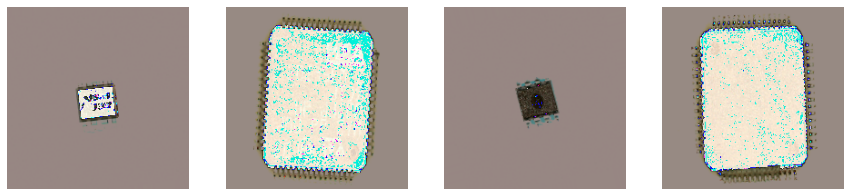

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

batch_size = 20
datagen = ImageDataGenerator(
        rotation_range=20, # rotation
        zoom_range=0.02, # zoom
        horizontal_flip=True, # horizontal flip
        preprocessing_function=preprocess_input
        )
datagen_valid = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_df = datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=home_path+'Train/Train_Images/',
                                              x_col="id", 
                                              y_col="label", 
                                              class_mode="binary", 
                                              target_size=(200, 200), 
                                              batch_size=batch_size,
                                              #rescale=1.0/255,
                                              shuffle=True,
                                              crop_to_aspect_ratio=True,
                                              seed=2023)

valid_generator_df = datagen_valid.flow_from_dataframe(dataframe=df_valid, 
                                              directory=home_path+'Train/Train_Images/',
                                              x_col="id", 
                                              y_col="label", 
                                              class_mode="binary", 
                                              target_size=(200, 200), 
                                              batch_size=batch_size,
                                              #rescale=1.0/255,
                                              shuffle=True,
                                              crop_to_aspect_ratio=True,
                                              seed=2023)

# plotting images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  img1 = next(train_generator_df)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  img1 = img1[0,...]

  # plot raw pixel data
  ax[i].imshow(img1)
  ax[i].axis('off')

# Section 3: Training Phase

**Transfer Learning**

*The VGG16 model which was originally proposed by  Karen Simonyan and Andrew Zisserman of the Visual Geometry Group Lab of Oxford University was used for this task as it had been trained on a subset of ImageNet Dataset and is widely regarded as one the best vision model architecture till date.*

Building on the same concept by our group as last year, this time the VGG16 model used is trained differently. First, to introduce regularization and avoid overfitting, a *dropout* layer is added before the final layer of the model. Second, instead of utlizing the entire VGG16 model as is, this one has the last two layers *unfrozen* so that these layers can be trained on our dataset and their weights can be updated by the predictions from the final layer. Third, this model has been trained with a *lower learning rate* and for less number of epochs (half of last year) to further reduce overfitting. 

This strategy has allowed us to reduce the training time by *half* of last year (10 minutes instead of 20 minutes for last year) and at the same time improve accuracy by *5%* of last year for Phase 1 (70% instead of 65% for last year).

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout

"""
input_shape: tuple - the shape of input images
n_classes: int - number of classes
optimizer: string - instantiated optimizer to use for training. Adam used here.
fine_tune: int - The number of pre-trained layers to unfreeze. If fine_tune=0 all pre-trained layers will be freezed for training.
"""
    
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):

    # Pretrained convolutional layers are loaded using the Imagenet weights with include_top=False to exclude fully-connnected layers
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
    
    # Defines how many layers to freeze during training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. custom fully-connected layers).
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model) # Flatten feature stack as a numpy array to feed to dense layer
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) # Dropout layer to reduce overfitting
    output_layer = Dense(1, activation='sigmoid')(top_model) # Final output layer with sigmoid activation function for binary classification
    
    # Group base model and fully-connected layers into a new Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
from keras.optimizers import Adam
input_shape = (200, 200, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=2
vgg16_model_ft = create_model(input_shape, n_classes, optim_1, fine_tune=2) # fine_tune=2 meaning last two layers of VGG16 model are unfrozen for training

In [ ]:
history = vgg16_model_ft.fit(train_generator_df, validation_data = valid_generator_df, epochs=50, verbose=1)

Epoch 1/50
3/3 [==============================] - 14s 5s/step - loss: 7.1267 - accuracy: 0.5333 - val_loss: 11.7864 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 11s 4s/step - loss: 5.9169 - accuracy: 0.7333 - val_loss: 2.5263 - val_accuracy: 0.6750
Epoch 3/50
3/3 [==============================] - 11s 4s/step - loss: 2.4965 - accuracy: 0.6833 - val_loss: 1.0308 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 11s 4s/step - loss: 1.8045 - accuracy: 0.8000 - val_loss: 2.9218 - val_accuracy: 0.7000
Epoch 5/50
3/3 [==============================] - 11s 4s/step - loss: 1.1668 - accuracy: 0.8167 - val_loss: 3.7933 - val_accuracy: 0.7000
Epoch 6/50
3/3 [==============================] - 10s 4s/step - loss: 0.8275 - accuracy: 0.8500 - val_loss: 1.8409 - val_accuracy: 0.7250
Epoch 7/50
3/3 [==============================] - 11s 4s/step - loss: 0.3441 - accuracy: 0.9333 - val_loss: 0.9928 - val_accuracy: 0.7500
Epoch 8/50
3/3 [=================

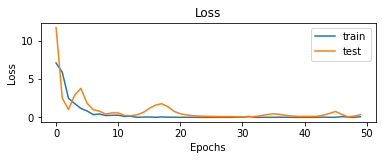

In [ ]:
# plot loss during training

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

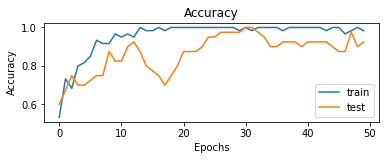

In [ ]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Save model to perform predictions later
from tensorflow.keras.models import save_model
save_model(vgg16_model_ft, "/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/vgg16_imp2.h5")

# Section 4: Testing Phase

In [ ]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/Test/test.csv')

In [ ]:
test['id'] = pd.Series(test['id'], dtype="string")
test['label'] = pd.Series(test['label'], dtype="string")

In [ ]:
# Function to append ".png" to id column in the dataframe to traverse file directory using the filenames from id column

def append_ext(fn):
    return fn+".png"
test["id"]=test["id"].apply(append_ext)

In [ ]:
test_generator_df = test_generator.flow_from_dataframe(dataframe=test, 
                                              directory=home_path+'Test/Test_Images/',
                                              x_col="id", 
                                              y_col="label", 
                                              class_mode="binary", 
                                              target_size=(200, 200), 
                                              batch_size=batch_size,
                                              #rescale=1.0/255,
                                              shuffle=True,
                                              crop_to_aspect_ratio=True,
                                              seed=2023)

Found 20 validated image filenames belonging to 2 classes.


In [ ]:
vgg_preds = vgg16_model_ft.predict(test_generator_df)

1/1 [==============================] - 3s 3s/step


In [ ]:
vgg_preds

array([[9.8248823e-03],
       [6.9643669e-05],
       [1.6871974e-01],
       [1.3125095e-03],
       [1.5026675e-01],
       [6.5089674e-03],
       [9.9285829e-01],
       [9.7498626e-01],
       [4.6146929e-01],
       [7.9725450e-01],
       [8.2210834e-05],
       [9.9944490e-01],
       [1.0660859e-03],
       [4.7451090e-06],
       [4.7011068e-01],
       [9.2904240e-01],
       [9.9779153e-01],
       [9.4725853e-01],
       [9.9994302e-01],
       [3.5892421e-01]], dtype=float32)

In [ ]:
# Converting raw probability values into classes

threshold = 0.5
predicted_classes = np.where(vgg_preds > threshold, 1,0)

In [ ]:
predicted_classes

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [ ]:
true_classes = test_generator_df.classes

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, predicted_classes)
print("Model Accuracy : {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy : 70.00%


In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_classes, predicted_classes)

print(cf_matrix)

[[8 2]
 [4 6]]


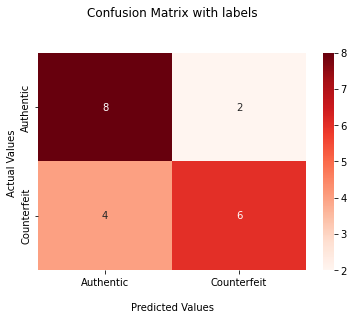

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Authentic','Counterfeit'])
ax.yaxis.set_ticklabels(['Authentic','Counterfeit'])

# Display the Confusion Matrix.
plt.show()

In [ ]:
# Generate precision, recall, f1-score and accuracy metrics
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



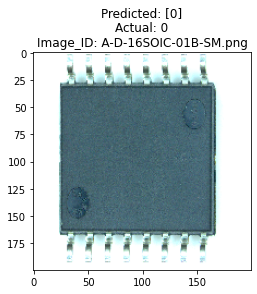

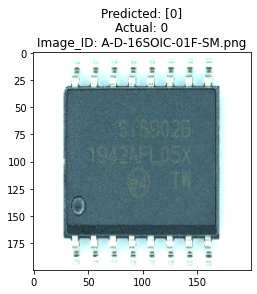

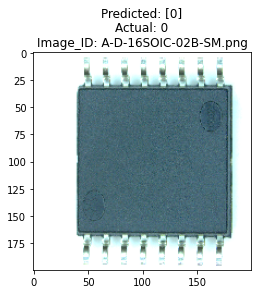

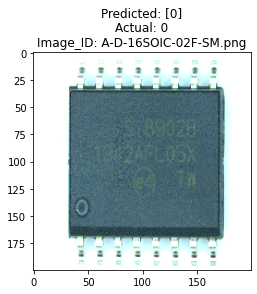

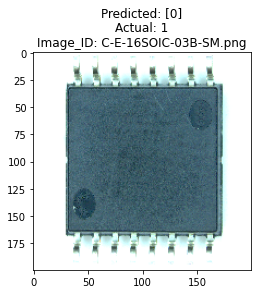

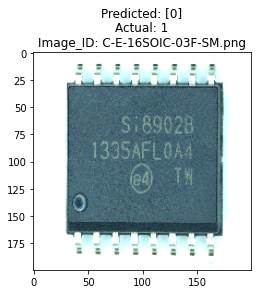

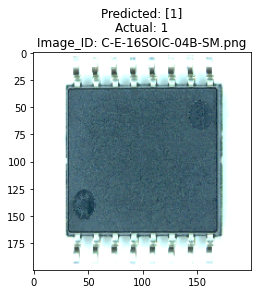

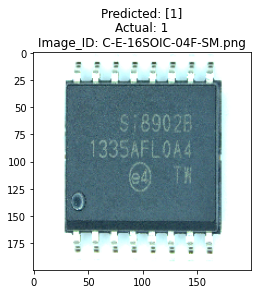

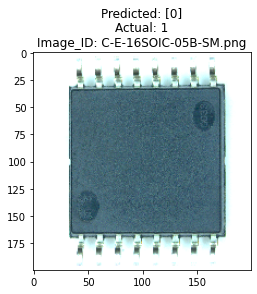

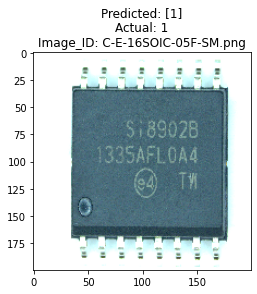

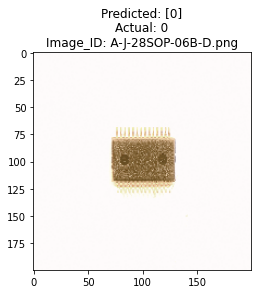

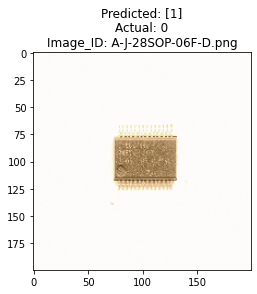

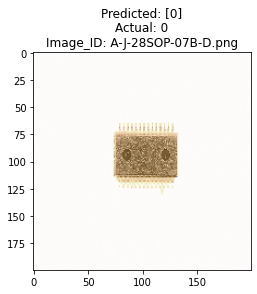

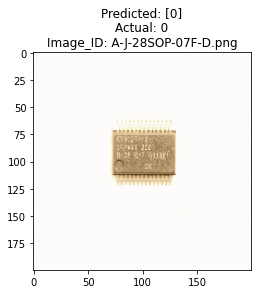

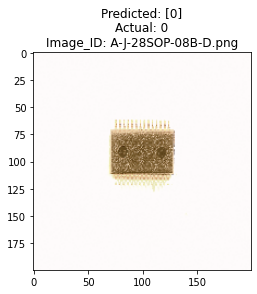

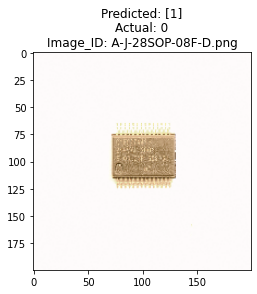

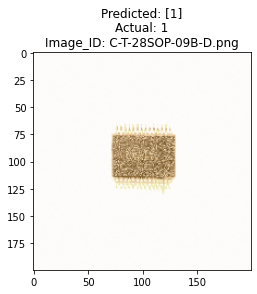

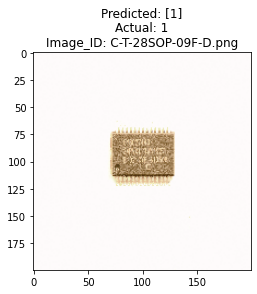

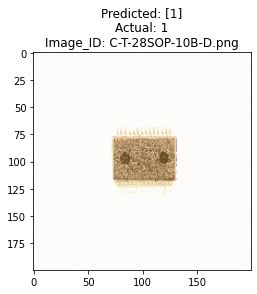

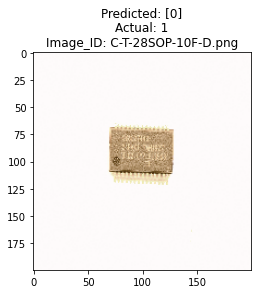

In [ ]:
# Generate predictions on each image of test data
import keras.utils as image
img_nr = 0
for subdir, dirs, files in os.walk('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/Test/Test_Images'):
    for file in test['id']:
        img_file = subdir + '/' + file
        imagex = image.load_img(img_file,target_size=(200,200))
        pred_emotion = predicted_classes[img_nr]
        real_emotion = true_classes[img_nr]
        plt.figure()
        plt.title('Predicted: ' + str(pred_emotion) + '\n' + 'Actual: ' + str(real_emotion) + '\n' + 'Image_ID: ' + str(file))
        plt.imshow(imagex)
        img_nr = img_nr +1

# Section 5: Loading saved model to make predictions

In [ ]:
# Required imports to ensure below code cells are run properly
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
# Connect google drive to google colab to give access to test images, labels and model file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Returns a saved compiled model
model = load_model('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/vgg16_imp2.h5') # Use appropriate path to the model file. Zip file will include the .h5 model file for evaluation.

In [ ]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # Utilizing the same preprocessing function employed in training phase

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/Test/test.csv') # Please use appropriate file paths to test file

In [ ]:
test['id'] = pd.Series(test['id'], dtype="string")
test['label'] = pd.Series(test['label'], dtype="string")

In [ ]:
# Function to append ".png" to id column in the dataframe to traverse file directory using the filenames from id column

def append_ext(fn):
    return fn+".png"
test["id"]=test["id"].apply(append_ext)

In [ ]:
# Define Home directory to provide path to test images in test generator. Your file paths may vary so use appropriate file paths here.
home_path = r'/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/'

batch_size = 20

test_generator_df = test_generator.flow_from_dataframe(dataframe=test, 
                                              directory=home_path+'Test/Test_Images/',
                                              x_col="id", 
                                              y_col="label", 
                                              class_mode="binary", 
                                              target_size=(200, 200), 
                                              batch_size=batch_size,
                                              #rescale=1.0/255,
                                              shuffle=True,
                                              crop_to_aspect_ratio=True,
                                              seed=2023)

Found 20 validated image filenames belonging to 2 classes.


In [ ]:
vgg_preds = model.predict(test_generator_df)

1/1 [==============================] - 12s 12s/step


In [ ]:
vgg_preds

array([[9.8249186e-03],
       [6.9643800e-05],
       [1.6871470e-01],
       [1.3124765e-03],
       [1.5026845e-01],
       [6.5092449e-03],
       [9.9285829e-01],
       [9.7498602e-01],
       [4.6147233e-01],
       [7.9725343e-01],
       [8.2212166e-05],
       [9.9944490e-01],
       [1.0660909e-03],
       [4.7451367e-06],
       [4.7011605e-01],
       [9.2904353e-01],
       [9.9779153e-01],
       [9.4725609e-01],
       [9.9994302e-01],
       [3.5893020e-01]], dtype=float32)

In [ ]:
# Convert raw probability values into classes

threshold = 0.5
predicted_classes = np.where(vgg_preds > threshold, 1,0)

In [ ]:
predicted_classes

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [ ]:
true_classes = test_generator_df.classes

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, predicted_classes)
print("Model Accuracy : {:.2f}%".format(vgg_acc * 100))

Model Accuracy : 70.00%


In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_classes, predicted_classes)

print(cf_matrix)

[[8 2]
 [4 6]]


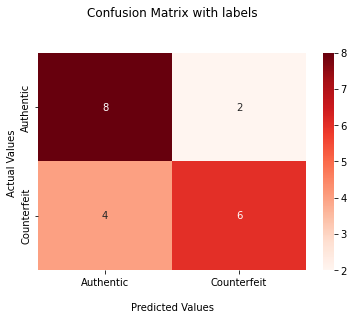

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Authentic','Counterfeit'])
ax.yaxis.set_ticklabels(['Authentic','Counterfeit'])

# Display the Confusion Matrix.
plt.show()

In [ ]:
# Generate metrics like precision, recall, f1-score and accuracy
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



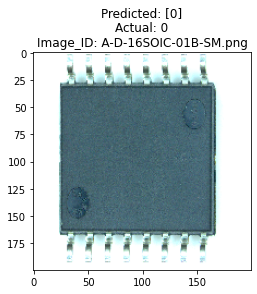

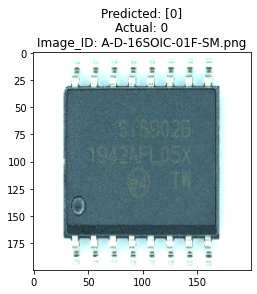

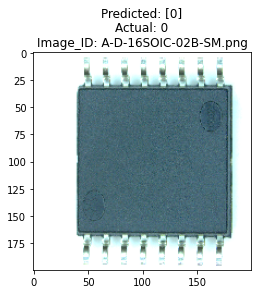

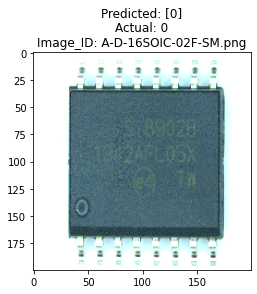

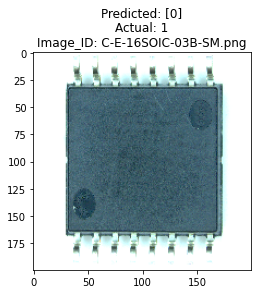

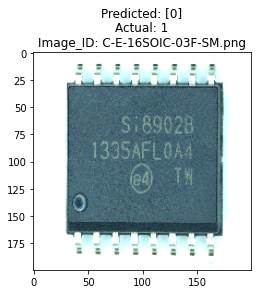

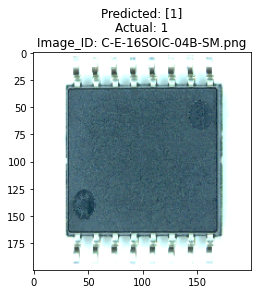

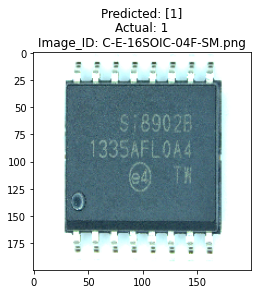

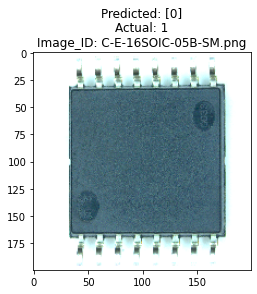

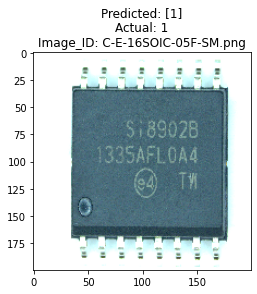

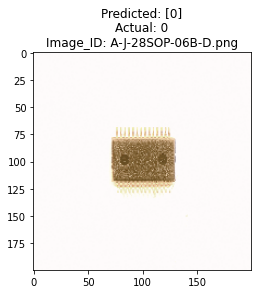

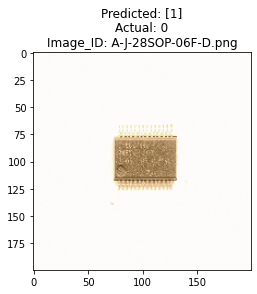

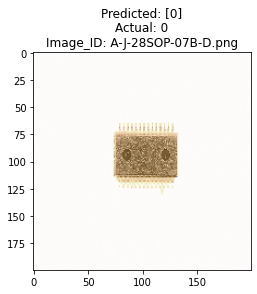

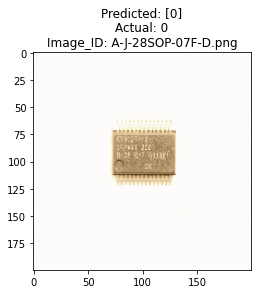

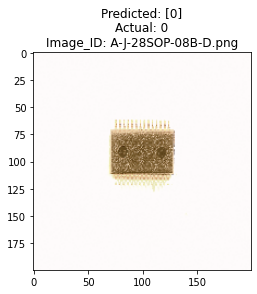

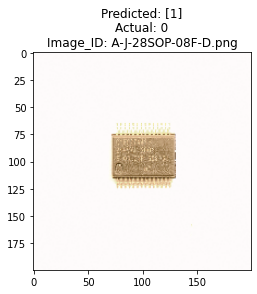

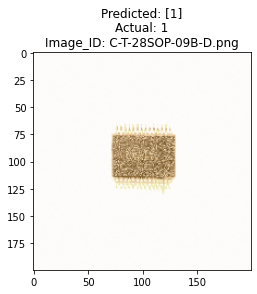

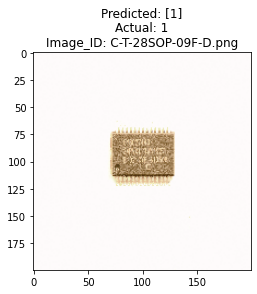

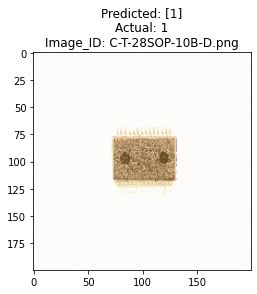

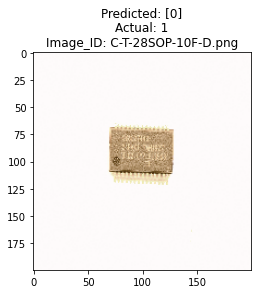

In [ ]:
# Generate predictions on each image of the test data
import os
import keras.utils as image
img_nr = 0
for subdir, dirs, files in os.walk('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/Test/Test_Images'):
    for file in test['id']:
        img_file = subdir + '/' + file
        imagex = image.load_img(img_file,target_size=(200,200))
        pred_emotion = predicted_classes[img_nr]
        real_emotion = true_classes[img_nr]
        plt.figure()
        plt.title('Predicted: ' + str(pred_emotion) + '\n' + 'Actual: ' + str(real_emotion) + '\n' + 'Image_ID: ' + str(file))
        plt.imshow(imagex)
        img_nr = img_nr +1